In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.chdir("/sfs/qumulo/qhome/jtb3sud/PARCv2")

import PARC.data.data_meta_learning as data
from PARC.model import model_meta_learning as model


2024-05-03 11:36:13.278056: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 11:36:18.298544: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46594 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:23:00.0, compute capability: 8.6


# Data pipeline

In [6]:
# Get data and normalization
state_seq_whole, vel_seq_whole = data.clip_raw_data(sequence_length = 54, n_state_var = 3, purpose = "diff_training", folder_path = '/scratch/jtb3sud/meta_data/tatb/training', image_size = (128, 208))
state_seq_norm = data.data_normalization(state_seq_whole,3)
vel_seq_norm = data.data_normalization(vel_seq_whole,2)

Processing 5793837.npy
Processing 5793840.npy
Processing 5793832.npy
Processing 5733384.npy
Processing 5793836.npy
Processing 5733394.npy
Processing 5793834.npy
Processing 5733387.npy
Processing 5793825.npy
Processing 5793838.npy
Processing 5793827.npy
Processing 5733388.npy
Processing 5733398.npy
Processing 5793826.npy
Processing 5793830.npy
Processing 5733385.npy
Processing 5733392.npy
Processing 5733400.npy
Processing 5733396.npy
Processing 5733391.npy
Processing 5733397.npy
Processing 5793831.npy
Processing 5733402.npy
Processing 5793839.npy


# Validation

In [7]:
state_seq_whole, vel_seq_whole = data.clip_raw_data(sequence_length = 54, n_state_var = 3, purpose = "test", folder_path = '/scratch/jtb3sud/meta_data/tatb/testing', image_size = (128, 208))
state_seq_norm_test = data.data_normalization_test(state_seq_whole, state_seq_norm[1], state_seq_norm[2],3)
vel_seq_norm_test = data.data_normalization_test(vel_seq_whole, vel_seq_norm[1], vel_seq_norm[2],2)

Processing 5793833.npy
Processing 5733390.npy
Processing 5733386.npy
Processing 5733401.npy
Processing 5733389.npy
Processing 5793829.npy
Processing 5793835.npy


In [ ]:
#print(state_seq_whole)
#print(vel_seq_whole)
#print(state_seq_norm_test)
#print(vel_seq_norm_test)

In [8]:
state_seq_whole.shape

(7, 128, 208, 162)

Image size: (128, 208)


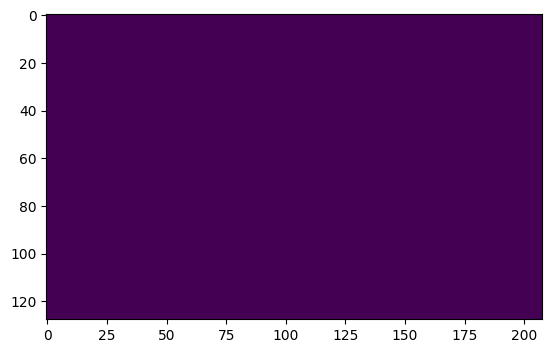

In [9]:
import matplotlib.pyplot as plt

# Assuming state_seq_norm_test is a numpy array containing image data
image = state_seq_norm_test[0, :, :, 0]

plt.imshow(image)

# Get the size of the image
image_size = image.shape
print("Image size:", image_size)
## 128 x 216 

## Load model

In [10]:
tf.keras.backend.clear_session()
parc_rk = model.PARCv2(n_state_var = 3, n_time_step = 59, step_size= 1/60, solver = "rk4", image_size = (128, 208))
parc_rk.compile()
parc_rk.differentiator.load_weights('/sfs/qumulo/qhome/jtb3sud/PARCv2/Pretrained_Weights/em/parc2_diff_rk4.h5')
parc_rk.integrator.load_weights('/sfs/qumulo/qhome/jtb3sud/PARCv2/Pretrained_Weights/em/parc2_int_rk4.h5')

In [20]:
print(state_seq_norm_test.shape)
print(vel_seq_norm_test.shape)

(7, 128, 208, 162)
(7, 128, 208, 108)


In [22]:
state_rk = []
outlier = []
for idx in range(2):
    if idx not in outlier:
        print(idx)
        #print(state_seq_norm_test)
        # what is the index helping with
        # why slice with these values?
        
        ## overall a data explanation is crucial for other users to have this 
        ## why must this equal 5 on the end? this should be explained
        state_var_current = state_seq_norm_test[3:4,:,:,39:42]
        velocity_current = vel_seq_norm_test[1:2,:,:,26:28]
        # Print shapes for debugging
        print("State shape:", state_var_current.shape)
        print("Velocity shape:", velocity_current.shape)
        ## detail what is being input here 
        pred_state = parc_rk.predict([state_var_current,velocity_current])
        pred_state_case = np.concatenate(pred_state, axis = -1)
        print(pred_state_case.shape)
        state_rk.append(pred_state_case)
state_rk = np.concatenate(state_rk, axis = 0)
print(state_rk.shape)       

0
State shape: (1, 128, 208, 3)
Velocity shape: (1, 128, 208, 2)


2024-05-03 12:26:51.900554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-05-03 12:26:52.812018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 418s 418s/step
(1, 128, 208, 295)
1
State shape: (1, 128, 208, 3)
Velocity shape: (1, 128, 208, 2)
1/1 [==============================] - 5s 5s/step
(1, 128, 208, 295)
(2, 128, 208, 295)


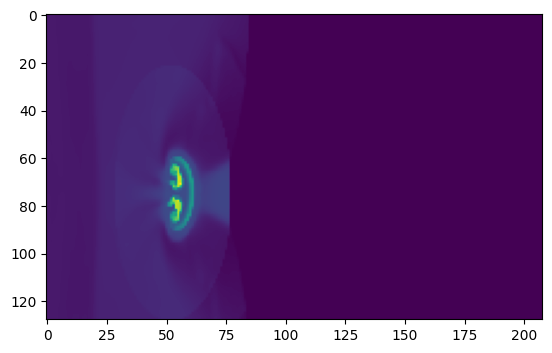

In [24]:
plt.imshow(state_seq_norm_test[6,:,:,39])

In [33]:
# how do we know the index range of 14? 
#for i in range(59):
#    ## what are these slices? phong has it at 8 
#    plt.imshow(state_rk[1,:,:,i*5], vmin = 0, vmax = 1, cmap = 'jet')
#    plt.show()

In [31]:
import matplotlib.pyplot as plt
from PIL import Image

# Initialize list to store frames
frames = []

for i in range(59):
    # Plot the image
    plt.imshow(state_rk[1, :, :, i * 5], vmin=0, vmax=1, cmap='jet')
    plt.axis('off')  # Turn off axis

    # Convert the figure to a PIL image
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove whitespace
    fig = plt.gcf()
    fig.canvas.draw()
    pil_image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

    # Close the plot to prevent display
    plt.close()

    # Append the PIL image to the frames list
    frames.append(pil_image)

# Save frames as a GIF
frames[0].save('state_rk_animation.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)


/tmp/ipykernel_131944/1659857244.py:16: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  pil_image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())


In [32]:
import PARC.visualization.visualization_em as viz
## visualization needs to be explained

In [34]:
# Denormalizing prediction data
pred_out = data.data_denormalization(state_rk,state_seq_norm[1] + vel_seq_norm[1],state_seq_norm[2] + vel_seq_norm[2], no_of_channel = 5)

In [35]:
# Save results file for plotting
np.save('/scratch/jtb3sud/parcv2_tatb.npy',pred_out)

In [ ]:
## how do I get gt??? This needs to be explained...
viz.plot_field_evolution(pred_out, )